In [1]:
from utils import *

In [2]:
boxes = [generate_box(0, 1000) for i in range(100)]
boxes[:10]

[array([[159, 159, 414, 414, 159, 159, 414, 414],
        [171, 374, 374, 171, 171, 374, 374, 171],
        [ 64,  64,  64,  64, 109, 109, 109, 109]]),
 array([[193, 193, 532, 532, 193, 193, 532, 532],
        [624, 183, 183, 624, 624, 183, 183, 624],
        [621, 621, 621, 621, 479, 479, 479, 479]]),
 array([[965, 965,  24,  24, 965, 965,  24,  24],
        [493, 185, 185, 493, 493, 185, 185, 493],
        [374, 374, 374, 374, 910, 910, 910, 910]]),
 array([[492, 492, 564, 564, 492, 492, 564, 564],
        [211, 289, 289, 211, 211, 289, 289, 211],
        [510, 510, 510, 510, 919, 919, 919, 919]]),
 array([[614, 614, 927, 927, 614, 614, 927, 927],
        [172, 237, 237, 172, 172, 237, 237, 172],
        [244, 244, 244, 244, 424, 424, 424, 424]]),
 array([[341, 341, 636, 636, 341, 341, 636, 636],
        [769, 342, 342, 769, 769, 342, 342, 769],
        [222, 222, 222, 222, 201, 201, 201, 201]]),
 array([[ 51,  51, 210, 210,  51,  51, 210, 210],
        [414, 992, 992, 414, 414, 992,

In [21]:
# Setup API
import requests
from requests.compat import urljoin
import json

In [34]:
api_host = "http://localhost"
boxes_endpoint = "boxes/"

boxes_url = urljoin(api_host, boxes_endpoint)
response = requests.get(url=boxes_url)
response.json()[:1]

ConnectionError: ('Connection aborted.', RemoteDisconnected('Remote end closed connection without response'))

In [36]:

for box in boxes:
    data = {
        "x_min": min(box[0]),
        "x_max": max(box[0]),
        "y_min": min(box[1]),
        "y_max": max(box[1]),
        "z_min": min(box[2]),
        "z_max": min(box[2]),
    }
    for key, value in data.items():
        data[key] = int(value)
    print(data)
    response = requests.post(urljoin(api_host, boxes_endpoint), json=data)
    assert response.status_code == 200, response.json()

{'x_min': 159, 'x_max': 414, 'y_min': 171, 'y_max': 374, 'z_min': 64, 'z_max': 64}


JSONDecodeError: [Errno Expecting value] Internal Server Error: 0

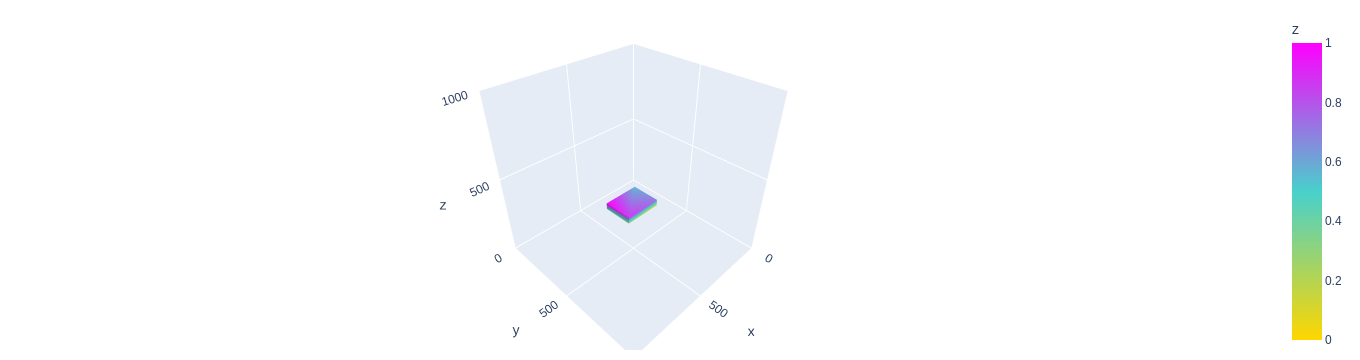

In [35]:
fig = go.Figure()

for box in boxes[:1]:
    add_mesh_3d(fig, box)

fig.update_layout(
    scene = {
        "xaxis": {
            "nticks": 4, 
            "range": [0,1000],
        },
        "yaxis": {
            "nticks": 4, 
            "range": [0, 1000],
        },
        "zaxis": {
            "nticks": 4, 
            "range": [0,1000],
        },
    },
    width=700,
    margin=dict(r=20, l=10, b=10, t=10))

fig.show()

In [ ]:
response = requests.get(